In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (18, 9)
plt.rcParams["font.size"] = 25
sns.set()

# Load Data

In [7]:
from google.colab import files
data = files.upload()

Saving data.csv to data.csv


In [20]:
df = pd.read_csv("data.csv")

In [21]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


# Treat Buy One Get One mail as treatment, Discount email as control

In [22]:


# Delete the data of people who didn't receive an offer
df = df.loc[df["offer"] != "No Offer"].reset_index(drop=True)


# dummify categorical variables
categorical_columns = ["zip_code", "channel"]
dummies = pd.get_dummies(df[categorical_columns], drop_first=True)
df = pd.concat([df.drop(categorical_columns, axis=1), dummies], axis=1)


# Keep explanatory variables separate
Columns = df.drop(["offer", "conversion"], axis=1).columns
X = df.drop(["offer", "conversion"], axis=1).values

# Treat Buy One Get One mail as treatment, Discount email as control
treatment_label = np.array(df.offer == "Discount").astype(int)
conversion_label = np.array(df.conversion == 1).astype(int)

In [23]:
df.head(8)

,recency,history,used_discount,used_bogo,is_referral,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,142.44,1,0,0,Buy One Get One,0,1,0,1,0
1,7,180.65,0,1,1,Buy One Get One,0,1,0,0,1
2,9,675.83,1,0,1,Discount,0,0,0,0,1
3,2,45.34,1,0,0,Buy One Get One,0,0,1,0,1
4,6,134.83,0,1,0,Buy One Get One,1,1,0,1,0
5,9,280.20,1,0,1,Buy One Get One,0,1,0,1,0
6,9,46.42,0,1,0,Buy One Get One,0,0,1,1,0
7,9,675.07,1,1,1,Discount,0,0,0,1,0


#Specifying Treatment & Control Group

In [24]:
is_treat = df[treatment_label==1]
not_treat = df[treatment_label==0]

In [26]:
df.groupby(["offer", "conversion", 'recency'])["conversion"].sum().unstack(level=[1,2]).sort_index(ascending=False)

conversion       0                             ...    1                      \
recency         1  2  3  4  5  6  7  8  9  10  ...   3    4    5    6    7    
offer                                          ...                            
Discount         0  0  0  0  0  0  0  0  0  0  ...  410  328  247  272  206   
Buy One Get One  0  0  0  0  0  0  0  0  0  0  ...  328  236  228  231  199   

conversion                                
recency           8    9    10   11   12  
offer                                     
Discount         181  327  377  168  124  
Buy One Get One  161  268  285  153  116  

[2 rows x 24 columns]

#Visualizing Treatment vs Control: History

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


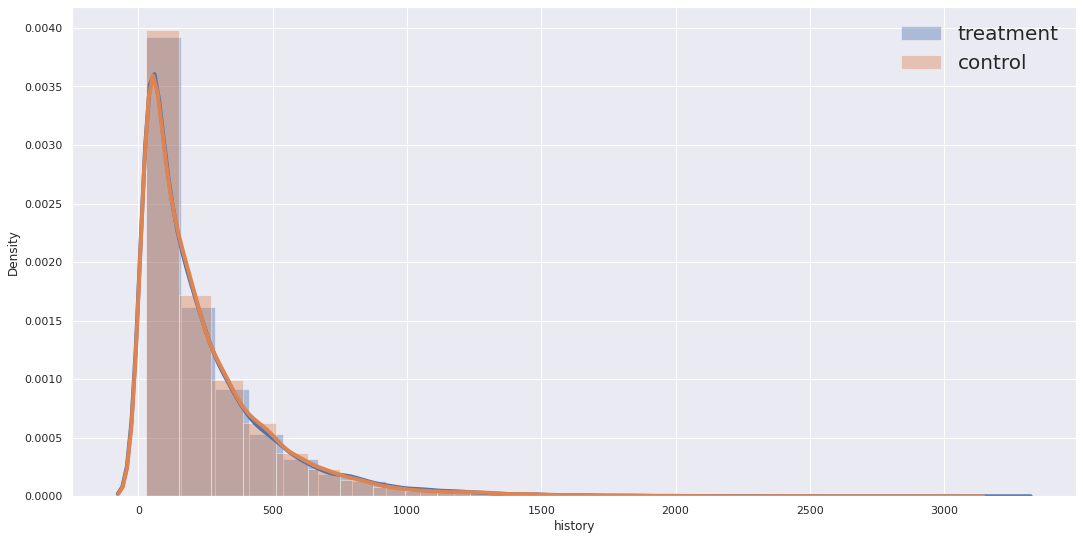

In [27]:
bins = 25

sns.distplot(is_treat.history, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.history, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='control')

plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

# Visualizing Treatment vs Control: Recency

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


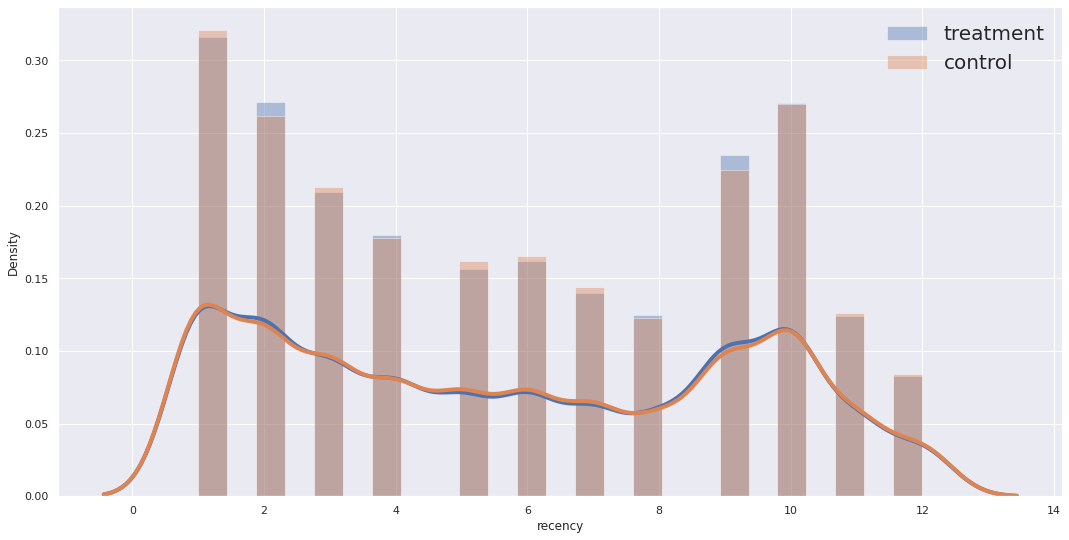

In [28]:
bins = 25

sns.distplot(is_treat.recency, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.recency, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='control')

plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

# Implementing Uplift Two-Model Approach

In [29]:
X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(X, treatment_label, conversion_label, test_size=0.5, random_state=42)

# Training the Model

In [30]:
# (probability of site visits when receiving intervention)
model_treat = LogisticRegression(C=0.01)
model_treat.fit(X_train[t_train == 1], y_train[t_train == 1])

# (probability of site visit without intervention)
model_control = LogisticRegression(C=0.01)
model_control.fit(X_train[t_train == 0], y_train[t_train == 0])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LogisticRegression(C=0.01)

In [31]:
print('###########      treatment')

for feature, coef in zip(Columns, model_treat.coef_[0]):
    print(f"{feature} / {round(coef, 4)}")

print('\n')
print('###########      control')

for feature, coef in zip(Columns, model_control.coef_[0]):
    print(f"{feature} / {round(coef, 4)}")

###########      treatment
recency / -0.0505
history / 0.0004
used_discount / 0.3111
used_bogo / 0.2855
is_referral / -0.4028
zip_code_Surburban / -0.1626
zip_code_Urban / -0.1459
channel_Phone / -0.0971
channel_Web / 0.0754


###########      control
recency / -0.0415
history / 0.0005
used_discount / 0.0704
used_bogo / 0.4379
is_referral / -0.3717
zip_code_Surburban / -0.1335
zip_code_Urban / -0.1744
channel_Phone / -0.1266
channel_Web / 0.1362


Treat: ROC AUC=0.613
Control: ROC AUC=0.616


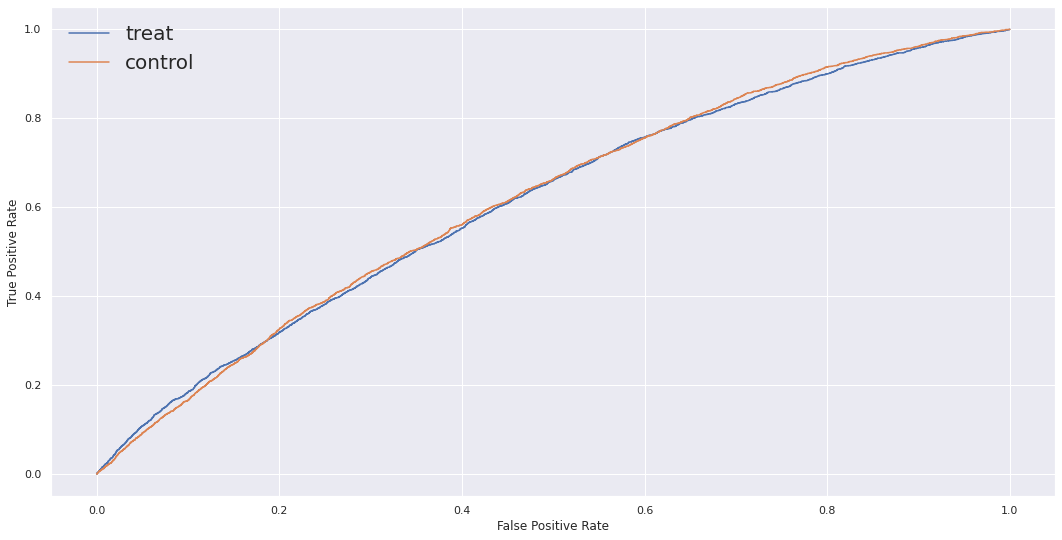

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

treat_auc = roc_auc_score(y_test, model_treat.predict_proba(X_test)[:, 1])
control_auc = roc_auc_score(y_test, model_control.predict_proba(X_test)[:, 1])

# summarize scores
print('Treat: ROC AUC=%.3f' % (treat_auc))
print('Control: ROC AUC=%.3f' % (control_auc))

# calculate roc curves
t_fpr, t_tpr, t_thresholds = roc_curve(y_test, model_treat.predict_proba(X_test)[:, 1])
c_fpr, c_tpr, c_thresholds = roc_curve(y_test, model_control.predict_proba(X_test)[:, 1])

# plot the roc curve for the model
plt.plot(t_fpr, t_tpr, label='treat')
plt.plot(c_fpr, c_tpr, label='control')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

In [33]:
print('treat accuracy: ', sum(model_treat.predict(X_test)==y_test)/len(y_test))
print('control accuracy: ', sum(model_control.predict(X_test)==y_test)/len(y_test))

treat accuracy:  0.8285941818522509
control accuracy:  0.8285941818522509


# Calculating Uplift_score

In [34]:
# Calculate (probability of site visit with intervention) - (probability of site visit without intervention) as uplift_score
proba_treat, proba_control = model_treat.predict_proba(X_test)[:, np.where(model_treat.classes_ == 1)].flatten(), model_control.predict_proba(X_test)[:, np.where(model_control.classes_ == 1)].flatten()
uplift_score = proba_treat - proba_control

df_result = pd.DataFrame({'y_test': y_test,
                          't_test': t_test,
                          'uplift': uplift_score}).sort_values(by=['uplift'], ascending=False)
                          
df_result.T

,20062,19917,5711,16967,13655,20278,20159,5492,9398,16852,...,4972,2019,20717,21163,19978,3232,9438,17282,16526,11665
y_test,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
t_test,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
uplift,0.092824,0.092817,0.09281,0.092739,0.092623,0.092531,0.092527,0.092458,0.092408,0.092381,...,-0.023021,-0.023289,-0.026178,-0.029955,-0.030325,-0.031519,-0.034553,-0.042353,-0.051168,-0.067886


#Plotting the Uplift score to visualize impact on Conversion Rate (CVR)

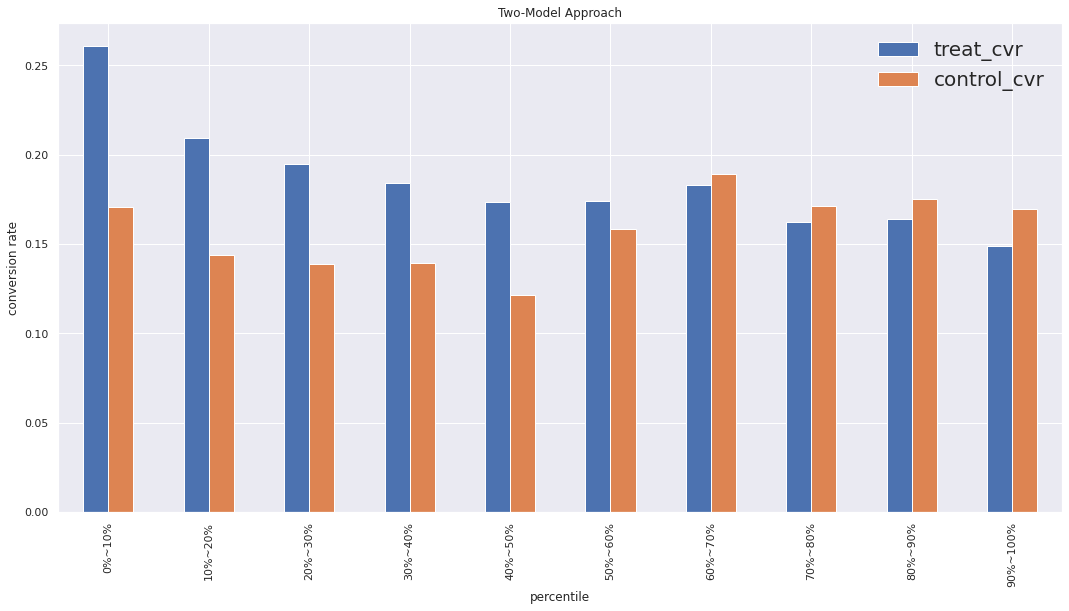

In [35]:
result = list(zip(y_test, t_test, uplift_score))
result.sort(key=lambda row: row[2], reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))
for n in range(10):
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]

    # count number of users in treatment group and control group
    treat_uu = list( map(lambda item: item[1], quantiled_result) ).count(True)
    control_uu = list( map(lambda item: item[1], quantiled_result) ).count(False)

    # count number of cv in treatment group and control group
    treat_cv = [item[0] for item in quantiled_result if bool(item[1]) is True].count(True)
    control_cv = [item[0] for item in quantiled_result if bool(item[1]) is False].count(True)

    # calculate cvr of treatment group and control group
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    label = '{}%~{}%'.format(n * 10, (n + 1) * 10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel('percentile')
plt.ylabel('conversion rate')
plt.title('Two-Model Approach')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

From the figure, It can be seen that for the lower percentiles( 0-60%) a higher conversion/response rate can be observed in the treatment group. (meaning the discount email intervention had an impact i.e. sending discount emails , led to higher response)

It can be seen that for the higher percentiles( 60% - 100%) a higher conversion/response rate can be observed in the control group. (meaning the BOGO emails which were used as control had an impact i.e. sending bogo emails , led to higher response)

In [36]:
len(result)
np.random.randint(len(result))

1056

#Compiling Uplift Model results

In [37]:
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

#   visit, treat, uplift
for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        # positive outcomes of fitst k samples
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        # positive outcomes of fitst k samples
        control_cvr = control_cv / control_uu

    lift = (treat_cvr - control_cvr) * treat_uu
    stat_data.append([
        is_cv, is_treat, score,
        treat_uu, control_uu, treat_cv, control_cv,
        treat_cvr, control_cvr, lift
    ])


# Convert statistical data to DataFrame
columns = [
    'is_cv', 'is_treat', 'score',
    'treat_uu', 'control_uu', 'treat_cv', 'control_cv',
    'treat_cvr', 'control_cvr', 'lift'
]

stat_df = pd.DataFrame(stat_data, columns=columns)


# add a baseline
stat_df['baseline'] = stat_df.index * stat_df['lift'][:] / len(stat_df.index)

stat_df.head()

,is_cv,is_treat,score,treat_uu,control_uu,treat_cv,control_cv,treat_cvr,control_cvr,lift,baseline
0,0,1,0.092824,1,0,0,0,0.00,0.0,0.0,0.000000
1,0,1,0.092817,2,0,0,0,0.00,0.0,0.0,0.000000
2,0,1,0.092810,3,0,0,0,0.00,0.0,0.0,0.000000
3,1,1,0.092739,4,0,1,0,0.25,0.0,1.0,0.000141
4,0,0,0.092623,4,1,1,0,0.25,0.0,1.0,0.000187


#Visualizing Area Under the Uplift Curve (AUUC)

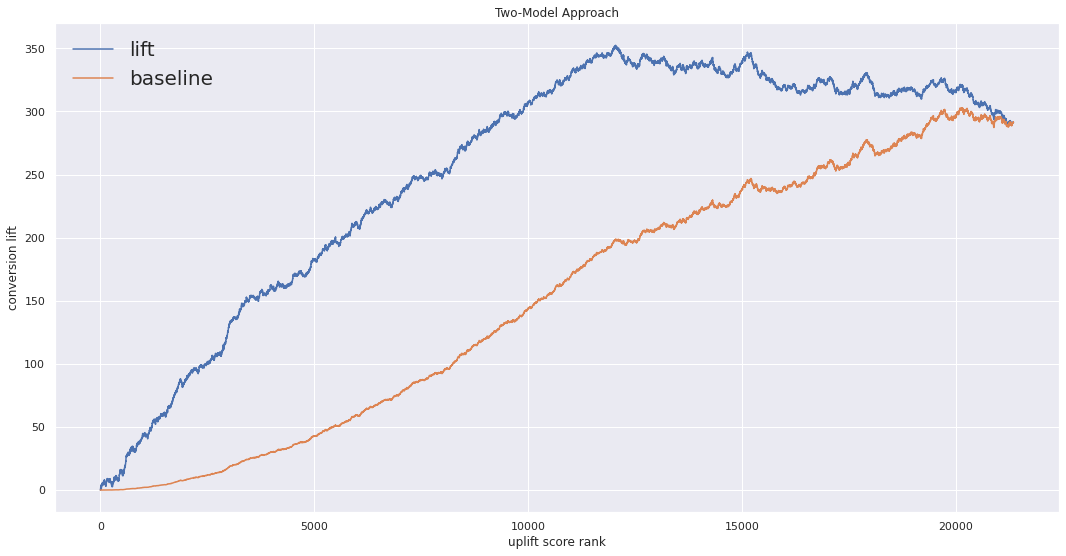

In [38]:
stat_df.plot(y=['lift', 'baseline'])

plt.xlabel('uplift score rank')
plt.ylabel('conversion lift')
plt.title('Two-Model Approach')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

In [39]:
stat_df.sort_values(by='score', ascending=False).loc[12200, 'score']

0.024666561657012087

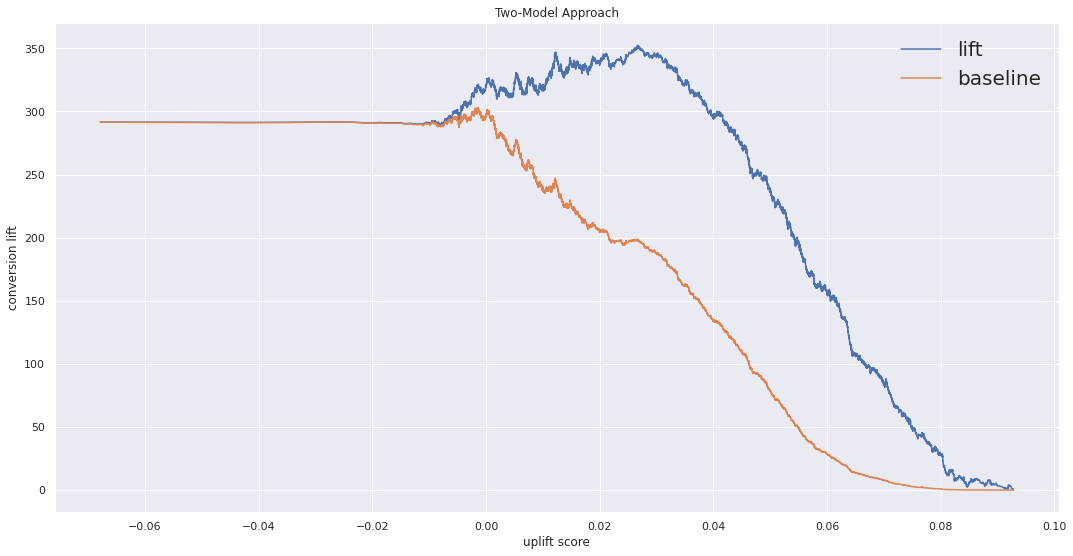

In [40]:
stat_df.plot(x='score', y=['lift','baseline'])
plt.xlabel('uplift score')
plt.ylabel('conversion lift')
plt.title('Two-Model Approach')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

In [41]:
AUUC = 0
test = 1./len(stat_df)
for i in range(len(stat_df)):
  height = stat_df.lift[i] - stat_df.baseline[i]
  AUUC += test * height

print('AUUC ', AUUC) 

AUUC  103.23605238262444


 This means that the strategy used in the campaign resulted in a significant uplift compared to the baseline, and that the strategy was effective in increasing the conversion rate.



In [42]:
print('num of treat ', len(df[treatment_label==1]))
print('num of control ', len(df[treatment_label==0]))

num of treat  21307
num of control  21387


# Visualizing  the distribution of of  proba_treat, proba_control, and stat_df using Density Plot

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 0, 'score / probability')

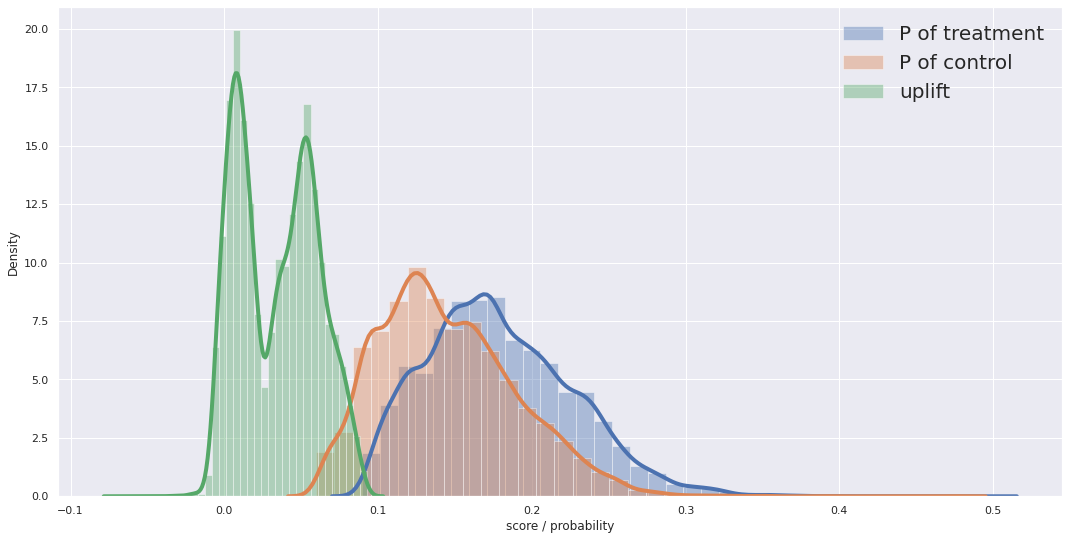

In [44]:
bins = 35

sns.distplot(proba_treat, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='P of treatment')
sns.distplot(proba_control, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='P of control')
sns.distplot(stat_df.score, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='uplift')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})
plt.xlabel('score / probability')

# Single Model Approach: Class Variable Transformation

In [47]:
# create z-label
z = t_train * y_train + (1 - t_train) * (1 - y_train)

# Easily check if P(G=T) = P(G=C) = 1/2
df[df.offer == "Discount"].shape[0] / df.shape[0]

0.49906310020143346

In [48]:
z

array([1, 0, 0, ..., 0, 1, 1])

# Training the Model

In [49]:

# a single model
single_model = LogisticRegression(C=0.01)
single_model.fit(X_train, z)

LogisticRegression(C=0.01)

In [50]:
for feature, coef in zip(Columns, single_model.coef_[0]):
    print(f"{feature} / {round(coef, 4)}")

recency / -0.004
history / 0.0
used_discount / 0.0643
used_bogo / -0.0272
is_referral / 0.0138
zip_code_Surburban / 0.0146
zip_code_Urban / 0.0069
channel_Phone / 0.0395
channel_Web / -0.011


# Predicting..

In [51]:
# calculate z score (z score = 2P(Z=1|X) - 1)
z_score = 2 * single_model.predict_proba(X_test)[:, 1] - 1

z_score

array([0.00876412, 0.04093717, 0.06340392, ..., 0.05827946, 0.0396383 ,
       0.04797054])

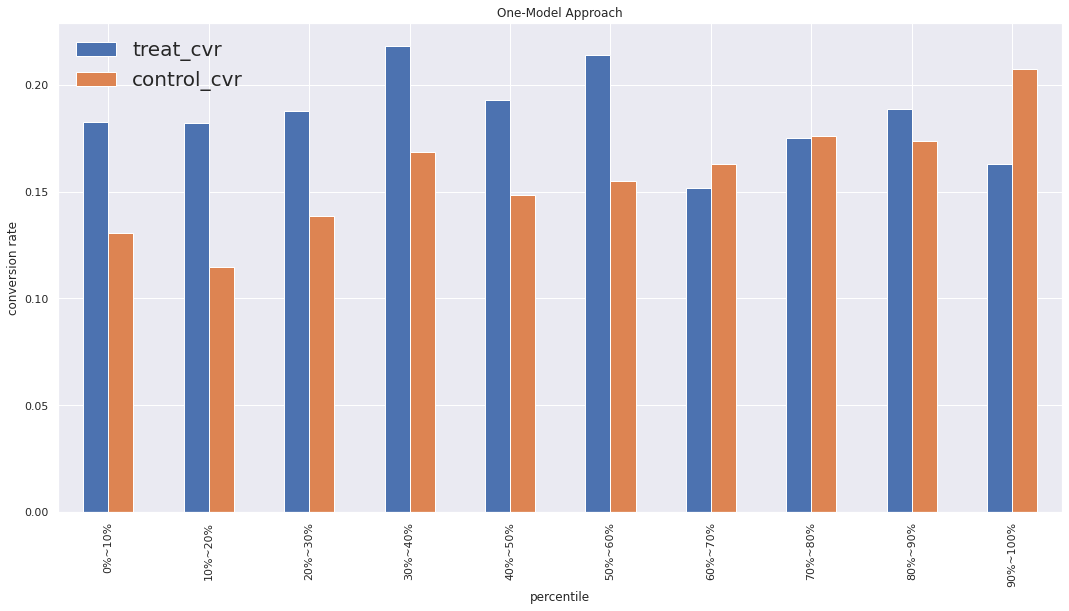

In [52]:
result = list(zip(y_test, t_test, z_score))
result.sort(key=lambda row: row[2], reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))
for n in range(10):
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]

    # count number of users in treatment group and control group
    treat_uu = list( map(lambda item: item[1], quantiled_result) ).count(True)
    control_uu = list( map(lambda item: item[1], quantiled_result) ).count(False)

    # count number of cv in treatment group and control group
    treat_cv = [item[0] for item in quantiled_result if bool(item[1]) is True].count(True)
    control_cv = [item[0] for item in quantiled_result if bool(item[1]) is False].count(True)

    # calculate cvr of treatment group and control group
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    label = '{}%~{}%'.format(n * 10, (n + 1) * 10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel('percentile')
plt.ylabel('conversion rate')
plt.title('One-Model Approach')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

Similar distribution with the 2-model approach across percentile groups

In [53]:
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

#   visit, treat, uplift
for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        # positive outcomes of fitst k samples
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        # positive outcomes of fitst k samples
        control_cvr = control_cv / control_uu

    lift = (treat_cvr - control_cvr) * treat_uu
    stat_data.append([
        is_cv, is_treat, score,
        treat_uu, control_uu, treat_cv, control_cv,
        treat_cvr, control_cvr, lift
    ])

# Convert statistical data to DataFrame
columns = [
    'is_cv', 'is_treat', 'score',
    'treat_uu', 'control_uu', 'treat_cv', 'control_cv',
    'treat_cvr', 'control_cvr', 'lift'
]

stat_df = pd.DataFrame(stat_data, columns=columns)

# add a baseline
stat_df['baseline'] = stat_df.index * stat_df['lift'][:] / len(stat_df.index)

# Visualizing Z score & Uplift Score for Single Model

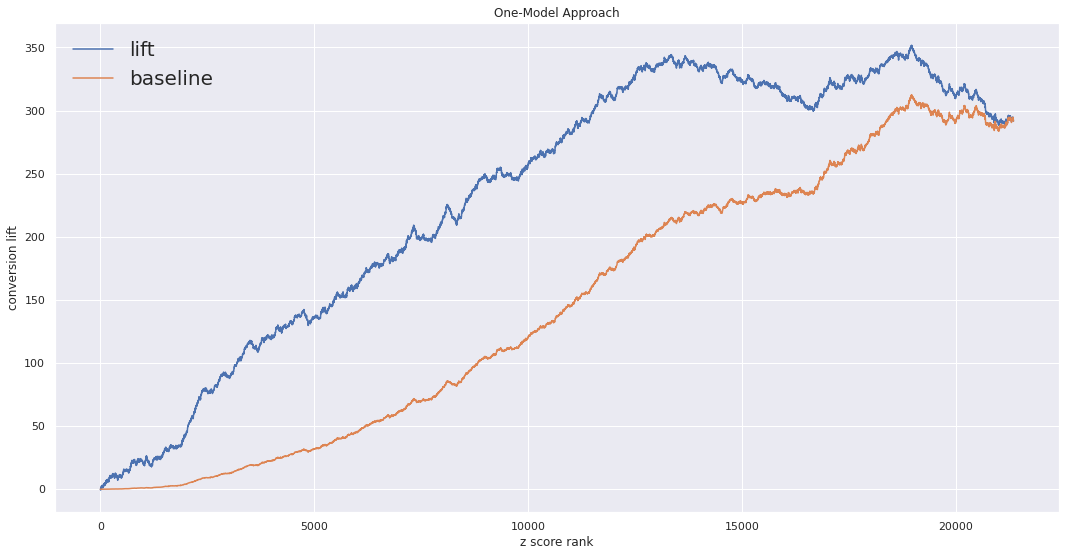

In [54]:
stat_df.plot(y=['lift', 'baseline'])

plt.xlabel('z score rank')
plt.ylabel('conversion lift')
plt.title('One-Model Approach')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

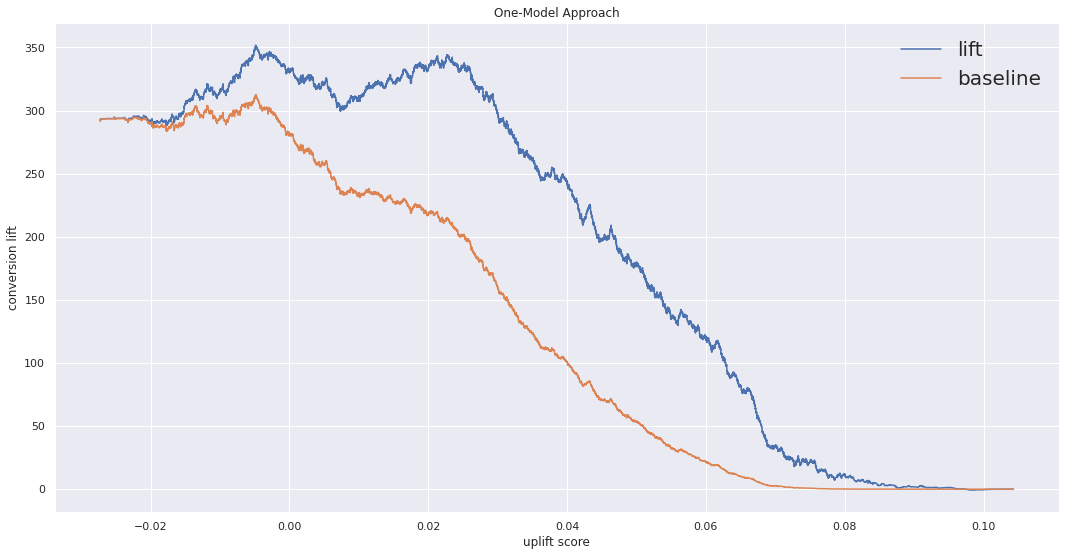

In [55]:
stat_df.plot(x='score', y=['lift','baseline'])
plt.xlabel('uplift score')
plt.ylabel('conversion lift')
plt.title('One-Model Approach')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20})

## References

- http://people.cs.pitt.edu/~milos/icml_clinicaldata_2012/Papers/Oral_Jaroszewitz_ICML_Clinical_2012.pdf
- https://qiita.com/usaito/items/af3fa59d0ee153a70350
- https://ysk24ok.github.io/2017/11/25/uplift_modeling.html